In [1]:
import re
import math
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

In [2]:
def preprocess_text(text, remPunct = True):
    # Preprocess the text by converting to lowercase and removing punctuation
    text = text.lower()
    if remPunct :
        text = re.sub(r'[^\w\s]', '', text)
    return text

# Method 1: Word Frequency

In [3]:
def calculate_cohesion_gaps(text, w):
    # Calculate the cohesion scores for each window of size w
    # Cohesion score = difference in word frequencies between two adjacent windows

    word_freqs = {}
    words = text.split()

    for i in range(len(words) - w + 1):
        window = words[i:i + w]
        word_freq = sum(window.count(word) for word in window)  # Frequency of words in the window
        word_freqs[i] = word_freq

    cohesion_gaps = {}
    for i in range(len(words) - w):
        if i == 0:
            cohesion_gaps[i] = 0
        else:
            cohesion_gaps[i] = abs(word_freqs[i] - word_freqs[i - 1])

    return cohesion_gaps

In [4]:
def calculate_cohesion_score(cohesion_gaps, k):
    # Calculate the mean of the top k% cohesion gaps
    sorted_gaps = sorted(cohesion_gaps.values(), reverse=True)
    k_percentile = int(math.ceil(k * len(sorted_gaps) / 100))

    return sum(sorted_gaps[:k_percentile]) / k_percentile

In [5]:
def topic_segmentation(text, w=100, k=10, s=20):
    # Perform text segmentation using TextTiling algorithm

    text = preprocess_text(text)
    words = text.split()

    # Step 1: Calculate the cohesion scores for each window of size w
    cohesion_gaps = calculate_cohesion_gaps(text, w)

    # Step 2: Calculate the mean of the top k% cohesion gaps
    cohesion_score = calculate_cohesion_score(cohesion_gaps, k)

    # Step 3: Identify potential boundaries using sentence-based segmentation
    boundaries = []
    current_boundary = 0

    for i in range(len(words) - w):
        if abs(cohesion_gaps[i] - cohesion_score) > cohesion_score / 2:
            if i - current_boundary > 2 * s:  # Ensure a minimum gap between boundaries
                boundaries.append(i)
                current_boundary = i

    # Step 4: Segment the text into topics based on the identified boundaries
    topics = []
    start = 0
    for boundary in boundaries:
        topics.append(' '.join(words[start:boundary]))
        start = boundary

    topics.append(' '.join(words[start:]))

    return topics

In [6]:
sample_text = """Text segmentation, also known as text splitting, is the process of dividing a continuous text into segments or sections based on some patterns or criteria. These segments are intended to represent different topics or themes present in the text. Text segmentation is a common technique used in natural language processing (NLP) and information retrieval tasks.
There are several methods and algorithms for text segmentation. One such method is called TextTiling. TextTiling is a technique developed by Marti Hearst in 1994. It is mainly used for segmenting longer texts, such as essays, articles, or documents. TextTiling relies on finding patterns in word frequencies and co-occurrences to identify boundaries between different topics.
In this example, we will implement a basic Python code to perform topic segmentation without using NLTK's TextTilingTokenizer. Instead, we will implement the segmentation from scratch based on the TextTiling algorithm.
Let's get started with the implementation."""

segmented_topics = topic_segmentation(sample_text)
for i, topic in enumerate(segmented_topics, start=1):
    print(f"Topic {i}:")
    print(topic.strip())
    print("-----------\n")


Topic 1:
text segmentation also known as text splitting is the process of dividing a continuous text into segments or sections based on some patterns or criteria these segments are intended to represent different topics or themes present in the text text segmentation is a
-----------

Topic 2:
common technique used in natural language processing nlp and information retrieval tasks there are several methods and algorithms for text segmentation one such method is called texttiling texttiling is a technique developed by marti hearst in 1994 it is mainly used for segmenting longer texts such as essays articles or documents texttiling relies on finding patterns in word frequencies and cooccurrences to identify boundaries between different topics in this example we will implement a basic python code to perform topic segmentation without using nltks texttilingtokenizer instead we will implement the segmentation from scratch based on the texttiling algorithm lets get started with the implement

# Method 2: Word frequency vectorizer with cosine similarity

In [7]:
def calculate_cosine_similarity(sentence1, sentence2):
    # Calculate cosine similarity between two sentences

    def vectorize(sentence):
        words = sentence.split()
        word_freq = {word: words.count(word) for word in set(words)}
        return word_freq

    vec_sentence1 = vectorize(sentence1)
    vec_sentence2 = vectorize(sentence2)

    intersection = set(vec_sentence1.keys()) & set(vec_sentence2.keys())
    dot_product = sum(vec_sentence1[word] * vec_sentence2[word] for word in intersection)

    magnitude1 = math.sqrt(sum(vec_sentence1[word] ** 2 for word in vec_sentence1))
    magnitude2 = math.sqrt(sum(vec_sentence2[word] ** 2 for word in vec_sentence2))
    
    if magnitude1 * magnitude2 == 0 :
        return 0
    else :
        return dot_product / (magnitude1 * magnitude2)

In [8]:
def calculate_cos_sentence_similarity(text):
    # Calculate cosine similarity between adjacent sentences in the text

    sentences = text.split('.')
    sentence_similarity = []

    for i in range(len(sentences) - 1):
        similarity = calculate_cosine_similarity(sentences[i], sentences[i + 1])
        sentence_similarity.append(similarity)

    return sentence_similarity

In [10]:
def topic_segmentation_sim(text, threshold=0.3):
    # Perform text segmentation based on sentence similarity

    text = preprocess_text(text, remPunct = False)

    # Step 1: Calculate sentence similarity scores
    sentence_similarity = calculate_cos_sentence_similarity(text)

    # Step 2: Identify potential boundaries based on sentence similarity
    boundaries = [0]

    for i in range(1, len(sentence_similarity)):
        if sentence_similarity[i] < threshold:
            boundaries.append(i)

    boundaries.append(len(sentence_similarity))

    # Step 3: Segment the text into topics based on the identified boundaries
    topics = []
    for i in range(len(boundaries) - 1):
        start = boundaries[i]
        end = boundaries[i + 1]
        topic_text = '.'.join(text.split('.')[start:end])
        topics.append(topic_text)

    return topics


In [13]:
sample_text = """
Text segmentation, also known as text splitting, is the process of dividing a continuous text into segments or sections based on some patterns or criteria. These segments are intended to represent different topics or themes present in the text. Text segmentation is a common technique used in natural language processing (NLP) and information retrieval tasks.

There are several methods and algorithms for text segmentation. One such method is called TextTiling. TextTiling is a technique developed by Marti Hearst in 1994. It is mainly used for segmenting longer texts, such as essays, articles, or documents. TextTiling relies on finding patterns in word frequencies and co-occurrences to identify boundaries between different topics.

In this example, we will implement a basic Python code to perform topic segmentation without using NLTK's TextTilingTokenizer. Instead, we will implement the segmentation based on sentence similarity using cosine similarity measure.

Let's get started with the implementation.
"""

segmented_topics = topic_segmentation_sim(sample_text, threshold=0.1)
for i, topic in enumerate(segmented_topics, start=1):
    print(f"Topic {i}:")
    print(topic.strip())
    print("-----------\n")


Topic 1:
text segmentation, also known as text splitting, is the process of dividing a continuous text into segments or sections based on some patterns or criteria. these segments are intended to represent different topics or themes present in the text. text segmentation is a common technique used in natural language processing (nlp) and information retrieval tasks
-----------

Topic 2:
there are several methods and algorithms for text segmentation. one such method is called texttiling
-----------

Topic 3:
texttiling is a technique developed by marti hearst in 1994
-----------

Topic 4:
it is mainly used for segmenting longer texts, such as essays, articles, or documents. texttiling relies on finding patterns in word frequencies and co-occurrences to identify boundaries between different topics.

in this example, we will implement a basic python code to perform topic segmentation without using nltk's texttilingtokenizer. instead, we will implement the segmentation based on sentence si

# Method 3: Using Embedding Model

In [14]:
sample_text = """
Text segmentation, also known as text splitting, is the process of dividing a continuous text into segments or sections based on some patterns or criteria. These segments are intended to represent different topics or themes present in the text. Text segmentation is a common technique used in natural language processing (NLP) and information retrieval tasks.

There are several methods and algorithms for text segmentation. One such method is called TextTiling. TextTiling is a technique developed by Marti Hearst in 1994. It is mainly used for segmenting longer texts, such as essays, articles, or documents. TextTiling relies on finding patterns in word frequencies and co-occurrences to identify boundaries between different topics.

In this example, we will implement a basic Python code to perform topic segmentation without using NLTK's TextTilingTokenizer. Instead, we will implement the segmentation based on sentence similarity using cosine similarity measure.

Let's get started with the implementation.
"""

segmented_topics = topic_segmentation_sim(sample_text, threshold=0.01)
for i, topic in enumerate(segmented_topics, start=1):
    print(f"Topic {i}:")
    print(topic.strip())
    print("-----------\n")

Topic 1:
text segmentation, also known as text splitting, is the process of dividing a continuous text into segments or sections based on some patterns or criteria. these segments are intended to represent different topics or themes present in the text. text segmentation is a common technique used in natural language processing (nlp) and information retrieval tasks
-----------

Topic 2:
there are several methods and algorithms for text segmentation. one such method is called texttiling. texttiling is a technique developed by marti hearst in 1994
-----------

Topic 3:
it is mainly used for segmenting longer texts, such as essays, articles, or documents. texttiling relies on finding patterns in word frequencies and co-occurrences to identify boundaries between different topics.

in this example, we will implement a basic python code to perform topic segmentation without using nltk's texttilingtokenizer. instead, we will implement the segmentation based on sentence similarity using cosine

In [15]:
def sentence_embed(sentences, model_name='paraphrase-MiniLM-L6-v2'):
    # Load the SentenceTransformer model
    model = SentenceTransformer(model_name)

    # Get sentence embeddings using the model
    embeddings = model.encode(sentences)

    return embeddings


In [ ]:
def calculate_sentence_similarity(embeddings):
    # Calculate cosine similarity between adjacent sentence embeddings
    similarities = []
    for i in range(len(embeddings) - 1):
        similarity = np.dot(embeddings[i], embeddings[i + 1]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[i + 1]))
        similarities.append(similarity)
    
    return similarities

In [ ]:
def topic_segmentation_embed(text, threshold=0.5):
    # Perform text segmentation based on sentence embeddings

    text = preprocess_text(text, remPunct = False)

    # Step 1: Tokenize sentences
    sentences = text.split('.')

    # Step 2: Vectorize sentences using SentenceTransformer
    embeddings = sentence_embed(sentences)

    # Step 3: Calculate sentence similarity
    sentence_similarity = calculate_sentence_similarity(embeddings)

    # Step 4: Identify potential boundaries based on sentence similarity
    boundaries = [0]

    for i in range(1, len(sentence_similarity)):
        if sentence_similarity[i] < threshold:
            boundaries.append(i)

    boundaries.append(len(sentence_similarity))

    # Step 5: Segment the text into topics based on the identified boundaries
    topics = []
    for i in range(len(boundaries) - 1):
        start = boundaries[i]
        end = boundaries[i + 1]
        topic_text = '.'.join(sentences[start:end])
        topics.append(topic_text)

    return topics

In [17]:
sample_text = """
Text segmentation, also known as text splitting, is the process of dividing a continuous text into segments or sections based on some patterns or criteria. These segments are intended to represent different topics or themes present in the text. Text segmentation is a common technique used in natural language processing (NLP) and information retrieval tasks.

There are several methods and algorithms for text segmentation. One such method is called TextTiling. TextTiling is a technique developed by Marti Hearst in 1994. It is mainly used for segmenting longer texts, such as essays, articles, or documents. TextTiling relies on finding patterns in word frequencies and co-occurrences to identify boundaries between different topics.

In this example, we will implement a basic Python code to perform topic segmentation using SentenceTransformer to vectorize sentences. SentenceTransformer provides pre-trained models for sentence embeddings, which allow us to capture semantic meaning and similarity between sentences.

Let's get started with the implementation.
"""

segmented_topics = topic_segmentation_embed(sample_text, threshold=0.4)
for i, topic in enumerate(segmented_topics, start=1):
    print(f"Topic {i}:")
    print(topic.strip())
    print("-----------\n")


Topic 1:
text segmentation, also known as text splitting, is the process of dividing a continuous text into segments or sections based on some patterns or criteria
-----------

Topic 2:
these segments are intended to represent different topics or themes present in the text. text segmentation is a common technique used in natural language processing (nlp) and information retrieval tasks.

there are several methods and algorithms for text segmentation. one such method is called texttiling. texttiling is a technique developed by marti hearst in 1994. it is mainly used for segmenting longer texts, such as essays, articles, or documents. texttiling relies on finding patterns in word frequencies and co-occurrences to identify boundaries between different topics.

in this example, we will implement a basic python code to perform topic segmentation using sentencetransformer to vectorize sentences
-----------

Topic 3:
sentencetransformer provides pre-trained models for sentence embeddings, whi

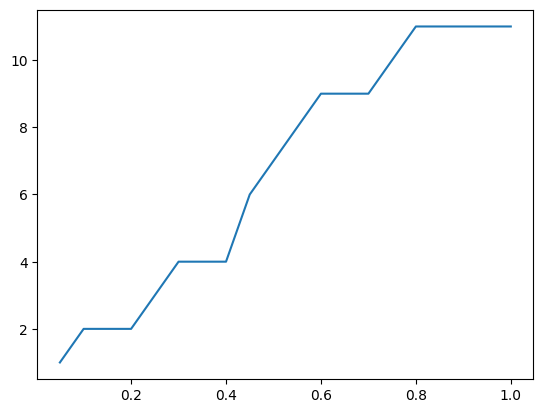

In [18]:
threshold = []
num_topics = []

for i in range(20) :
    thres = 0 + (i+1)/20.0
    segmented_topics = topic_segmentation_embed(sample_text, threshold=thres)
    threshold.append(thres)
    num_topics.append(len(segmented_topics))
    
plt.plot(threshold, num_topics)

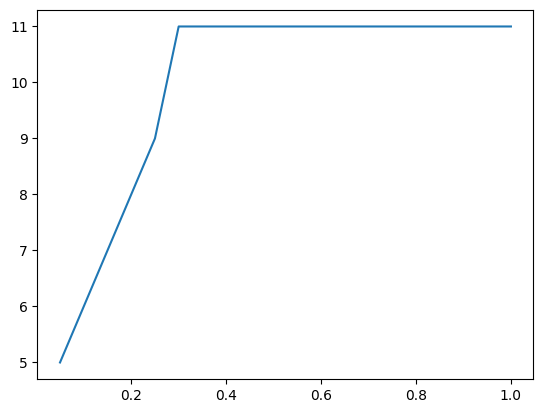

In [19]:
threshold = []
num_topics = []

for i in range(20) :
    thres = 0 + (i+1)/20.0
    segmented_topics = topic_segmentation_sim(sample_text, threshold=thres)
    threshold.append(thres)
    num_topics.append(len(segmented_topics))
    
plt.plot(threshold, num_topics)